In [1]:
from collections import OrderedDict
from functools import partial
from time import time

import matplotlib.pyplot as plt
import matplotlib.cm as cm
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import NullFormatter
import numpy as np
import pandas as pd

from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn import manifold
from sklearn.manifold import TSNE, Isomap
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.preprocessing import MinMaxScaler

from umap import UMAP
from hdbscan import HDBSCAN

C:\Users\weld.c\AppData\Roaming\Python\Python38\site-packages\umap\__init__.py:9: UserWarning: Tensorflow not installed; ParametricUMAP will be unavailable
  warn("Tensorflow not installed; ParametricUMAP will be unavailable")


In [2]:
# Loading the data file:
data = pd.read_excel('readcounts.xlsx')
data

,Unnamed: 0,H223,H224,H225,H226,H227,H228,H229,H230,H231,...,H261,H262,H263,H264,H265,H266,H267,H268,H269,H270
0,ENSG00000000003,0,0,0,1,0,0,0,0,1,...,0,1,0,1,0,2,0,0,1,0
1,ENSG00000000005,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2,ENSG00000000419,1216,1228,1022,912,491,449,466,727,774,...,980,932,360,450,484,926,803,630,537,582
3,ENSG00000000457,189,114,110,289,186,148,169,258,145,...,117,286,137,90,105,275,101,56,87,81
4,ENSG00000000460,74,38,55,127,30,17,45,100,33,...,28,157,34,20,15,139,54,25,21,47
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65210,ENSG00000281918,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
65211,ENSG00000281919,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
65212,ENSG00000281920,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
65213,ENSG00000281921,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
# Transposing the data:
columns = data.loc[:, 'Unnamed: 0'].values
data = data.drop(columns=['Unnamed: 0'])
data = data.transpose()
data.columns = columns
data

,ENSG00000000003,ENSG00000000005,ENSG00000000419,ENSG00000000457,ENSG00000000460,ENSG00000000938,ENSG00000000971,ENSG00000001036,ENSG00000001084,ENSG00000001167,...,ENSG00000281913,ENSG00000281914,ENSG00000281915,ENSG00000281916,ENSG00000281917,ENSG00000281918,ENSG00000281919,ENSG00000281920,ENSG00000281921,ENSG00000281922
H223,0,0,1216,189,74,31895,2,763,8963,1589,...,0,0,0,0,0,0,0,0,0,0
H224,0,0,1228,114,38,23361,3,712,26794,1734,...,0,0,0,0,0,0,0,0,0,0
H225,0,0,1022,110,55,27944,0,956,8027,1341,...,0,0,0,0,0,0,0,0,0,0
H226,1,0,912,289,127,41846,6,1104,716,1053,...,0,0,0,0,0,0,0,0,0,0
H227,0,0,491,186,30,11929,14,136,745,730,...,0,0,0,0,0,0,0,0,0,0
H228,0,0,449,148,17,6856,16,227,3770,663,...,0,0,0,0,0,0,0,0,0,0
H229,0,0,466,169,45,6756,15,217,1260,669,...,0,0,0,0,0,0,0,0,0,0
H230,0,0,727,258,100,7668,4,905,1480,883,...,0,0,0,0,0,0,0,0,0,0
H231,1,0,774,145,33,9315,1,94,75,873,...,0,0,0,0,0,0,0,0,0,0
H232,0,0,576,131,8,3319,7,88,288,678,...,0,0,0,0,0,0,0,0,0,0


# Data Normalization:

In [4]:
x_array = data.loc[:, data.columns].values
x_array_norm = MinMaxScaler().fit_transform(x_array)
x_array.shape

(48, 65215)

# Embeddings:

In [5]:
n_components = 10
n_neighbors = 10

methods = OrderedDict()
methods['PCA'] = PCA(n_components=n_components)
methods['Isomap'] = manifold.Isomap(n_neighbors=n_neighbors, n_components=n_components)
methods['MDS'] = manifold.MDS(n_components=n_components, max_iter=100, n_init=1)
methods['SE'] = manifold.SpectralEmbedding(n_components=n_components, n_neighbors=n_neighbors)
methods['UMAP'] = UMAP(n_components=n_components, init='random', random_state=0)

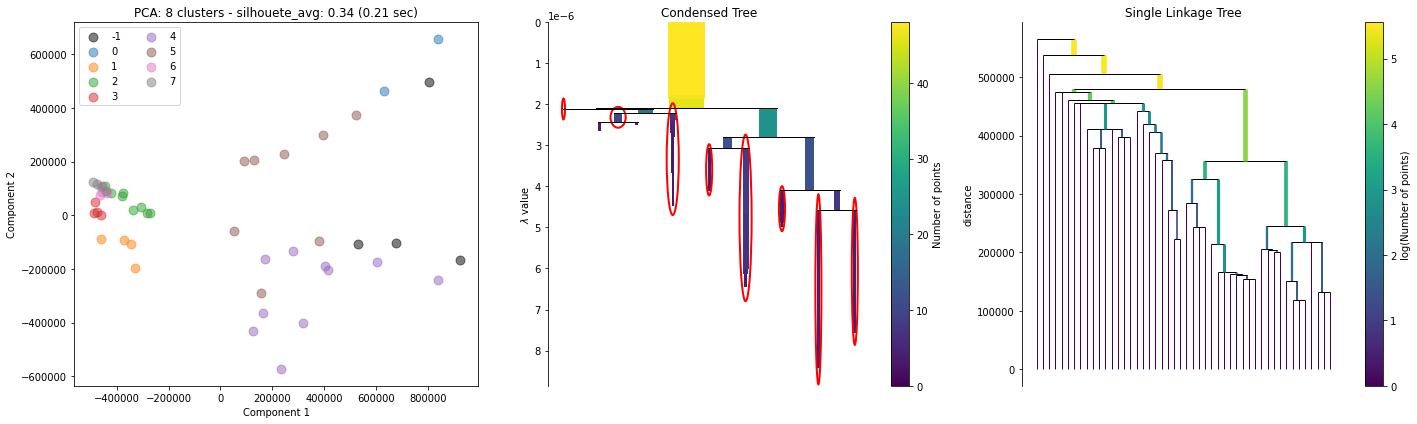

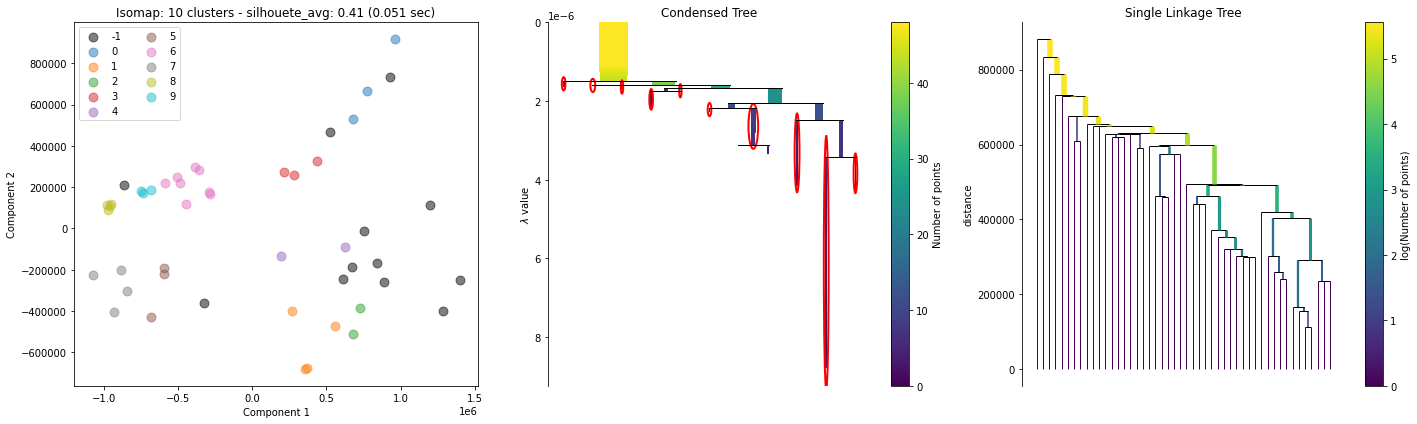

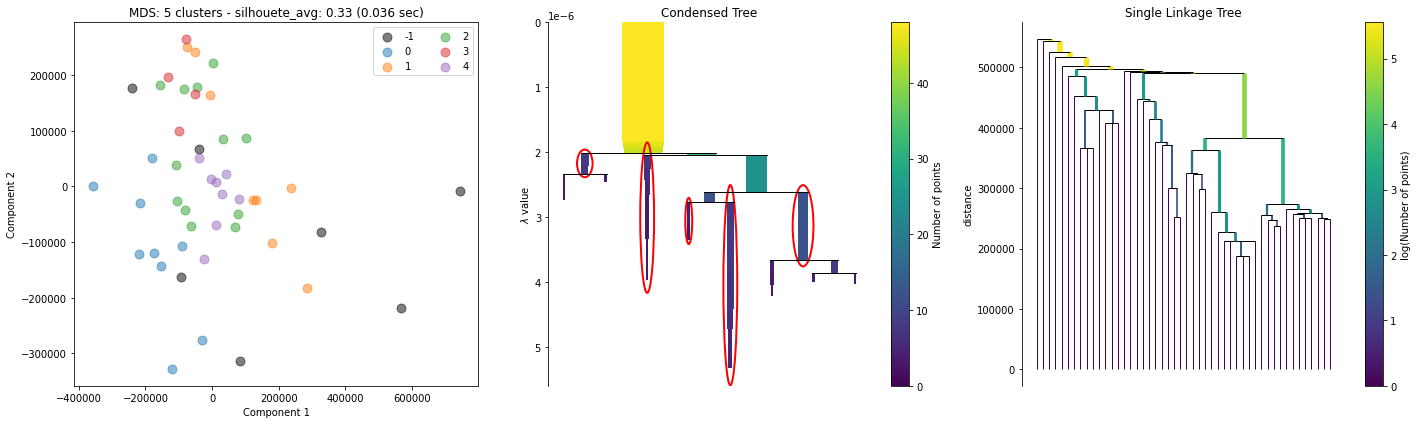

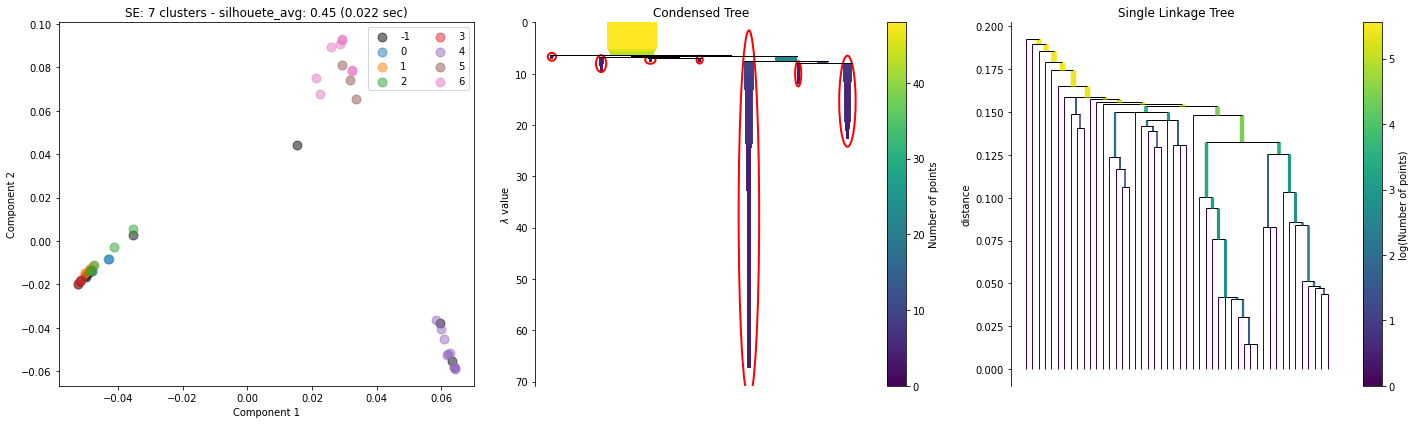

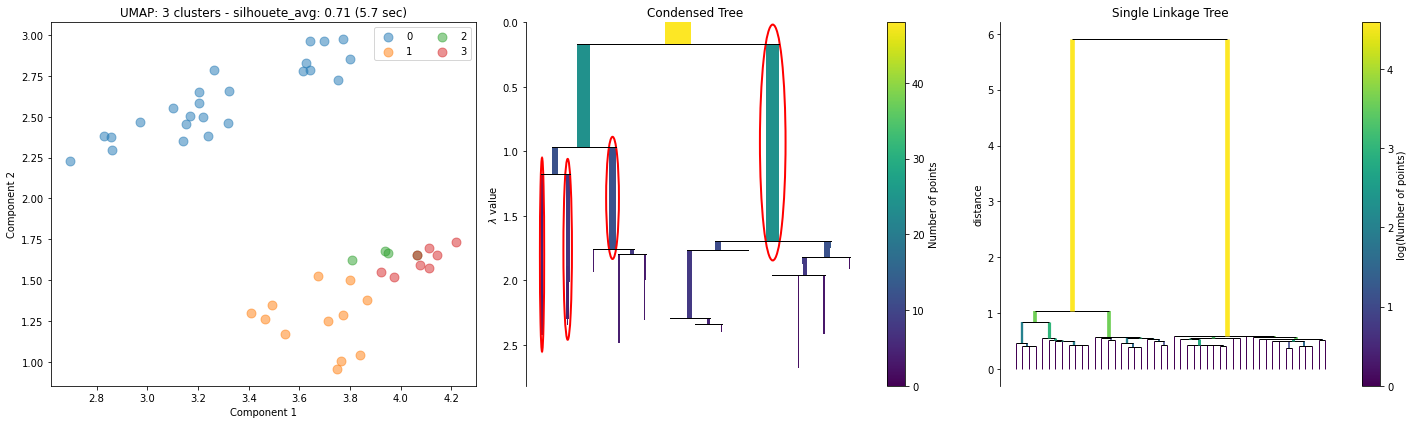

In [6]:
results = pd.DataFrame()
metrics_summary = []

for i, (label, method) in enumerate(methods.items()):
    # Performing the embedding algorithm:
    t0 = time()
    x_embedded = method.fit_transform(x_array)
    t1 = time()
    
    model = HDBSCAN(min_cluster_size=2, min_samples=2)
    model.fit(x_embedded)
    cluster_labels = model.labels_
    results[label] = cluster_labels

    sample_silhouette_values = silhouette_samples(x_embedded, cluster_labels)
    silhouette_avg = sample_silhouette_values[np.where(cluster_labels >= 0)[0]].mean()
    
    n_clusters = len(np.unique(cluster_labels))-1
    method_metrics = {'silhouette_avg': silhouette_avg, 'n_clusters': n_clusters,
                      'n_outliers': sum(cluster_labels == -1)}
    metrics_summary.append(method_metrics)
    
    fig = plt.figure(figsize=(20, 6))
    # Plot 1:
    ax = fig.add_subplot(1, 3, 1)
    ax.set_title("%s: %d clusters - silhouete_avg: %.2g (%.2g sec)" % (label, n_clusters, silhouette_avg, t1 - t0))
    for k in np.unique(cluster_labels):
        indexes = np.where(cluster_labels == k)[0]
        if k == -1:
            plt.scatter(x_embedded[indexes, 0], x_embedded[indexes, 1], alpha=0.5, s=80, label=k, c='k')
        else:
            plt.scatter(x_embedded[indexes, 0], x_embedded[indexes, 1], alpha=0.5, s=80, label=k)
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.legend(ncol=2)
    # Plot 2:
    ax = fig.add_subplot(1, 3, 2)
    plt.title('Condensed Tree')
    model.condensed_tree_.plot(select_clusters=True)
    
    # Plot 3:
    ax = fig.add_subplot(1, 3, 3)
    plt.title('Single Linkage Tree')
    model.single_linkage_tree_.plot()
        
    plt.tight_layout()
    plt.savefig(f'img_0{i+1}_{label}_plots.png', dpi=100)
    plt.show()

In [7]:
results.index = data.index
results[0:16]

,PCA,Isomap,MDS,SE,UMAP
H223,1,5,3,5,2
H224,2,6,4,6,3
H225,2,6,4,6,3
H226,3,7,2,-1,1
H227,5,4,1,-1,0
H228,0,0,-1,1,0
H229,5,0,1,1,0
H230,6,8,2,4,1
H231,4,1,0,0,0
H232,-1,-1,-1,-1,0


In [8]:
results[16:32]

,PCA,Isomap,MDS,SE,UMAP
H239,5,1,1,0,0
H240,5,-1,1,1,0
H241,5,3,1,2,0
H242,6,9,2,4,1
H243,4,1,-1,0,0
H244,-1,-1,-1,-1,0
H245,4,-1,0,-1,0
H246,7,9,2,4,1
H247,1,5,3,5,2
H248,2,6,4,6,3


In [9]:
results[32:48]

,PCA,Isomap,MDS,SE,UMAP
H255,4,1,0,0,0
H256,4,-1,0,3,0
H257,4,-1,0,2,0
H258,7,8,2,4,1
H259,1,5,3,5,2
H260,2,6,4,6,3
H261,2,6,4,6,3
H262,3,7,2,-1,1
H263,5,4,1,-1,0
H264,5,3,1,2,0


In [10]:
metrics_summary = pd.DataFrame(metrics_summary, index=results.columns)
metrics_summary

,silhouette_avg,n_clusters,n_outliers
PCA,0.336438,8,4
Isomap,0.411451,10,12
MDS,0.331423,5,7
SE,0.447267,7,10
UMAP,0.714323,3,0


In [11]:
# Presenting all elements of all groups by all methods:
all_groups = {}

for method in results.columns:
    print('\n'+method+':')
    all_groups[method] = {}

    method_results = results[method].values
    for val in np.unique(method_results):
        print(val, results.index[np.where(method_results == val)[0]].values)
        all_groups[method][val] = list(results.index[np.where(method_results == val)[0]])


PCA:
-1 ['H232' 'H244' 'H251' 'H253']
0 ['H228' 'H252']
1 ['H223' 'H235' 'H247' 'H259']
2 ['H224' 'H225' 'H236' 'H237' 'H248' 'H249' 'H260' 'H261']
3 ['H226' 'H238' 'H250' 'H262']
4 ['H231' 'H233' 'H243' 'H245' 'H255' 'H256' 'H257' 'H267' 'H268' 'H269']
5 ['H227' 'H229' 'H239' 'H240' 'H241' 'H263' 'H264' 'H265']
6 ['H230' 'H242' 'H254' 'H266']
7 ['H234' 'H246' 'H258' 'H270']

Isomap:
-1 ['H232' 'H233' 'H235' 'H240' 'H244' 'H245' 'H251' 'H253' 'H256' 'H257'
 'H266' 'H268']
0 ['H228' 'H229' 'H252']
1 ['H231' 'H239' 'H243' 'H255']
2 ['H267' 'H269']
3 ['H241' 'H264' 'H265']
4 ['H227' 'H263']
5 ['H223' 'H247' 'H259']
6 ['H224' 'H225' 'H236' 'H237' 'H248' 'H249' 'H260' 'H261']
7 ['H226' 'H238' 'H250' 'H262']
8 ['H230' 'H234' 'H254' 'H258']
9 ['H242' 'H246' 'H270']

MDS:
-1 ['H228' 'H232' 'H243' 'H244' 'H251' 'H252' 'H253']
0 ['H231' 'H233' 'H245' 'H255' 'H256' 'H257' 'H267' 'H268' 'H269']
1 ['H227' 'H229' 'H239' 'H240' 'H241' 'H263' 'H264' 'H265']
2 ['H226' 'H230' 'H234' 'H238' 'H242' 'H246

In [12]:
all_clusters = []
all_relations = {}

# Concatenating the results of all methods:
for subject in results.index:
    related_subjects = []
    g_indexes = results.loc[subject, :].values
    n_out = len(np.where(g_indexes == -1)[0])
    if n_out < len(g_indexes)/2:
        all_partners = []
        for method, idx in zip(results.columns, g_indexes):
            if idx != -1:
                all_partners += all_groups[method][idx]
        all_partners = np.array(all_partners)
        all_partners = all_partners[~(all_partners == subject)]
        unique, counts = np.unique(all_partners, return_counts=True)
        for val, c in zip(unique, counts):
            if c > len(g_indexes)/2:
                related_subjects.append(val)
    
    new_cluster = set(related_subjects + [subject])
    if related_subjects and new_cluster not in all_clusters:
        all_clusters.append(new_cluster)
    all_relations[subject] = related_subjects
        
    print('Subject:', subject, 'related subjects:', related_subjects)

Subject: H223 related subjects: ['H235', 'H247', 'H259']
Subject: H224 related subjects: ['H225', 'H236', 'H237', 'H248', 'H249', 'H260', 'H261']
Subject: H225 related subjects: ['H224', 'H236', 'H237', 'H248', 'H249', 'H260', 'H261']
Subject: H226 related subjects: ['H238', 'H250', 'H262']
Subject: H227 related subjects: ['H229', 'H239', 'H240', 'H241', 'H263', 'H264', 'H265']
Subject: H228 related subjects: ['H229', 'H252']
Subject: H229 related subjects: ['H227', 'H228', 'H239', 'H240', 'H241', 'H252', 'H263', 'H264', 'H265']
Subject: H230 related subjects: ['H234', 'H238', 'H242', 'H246', 'H250', 'H254', 'H258', 'H266', 'H270']
Subject: H231 related subjects: ['H233', 'H239', 'H243', 'H245', 'H255', 'H256', 'H257', 'H267', 'H268', 'H269']
Subject: H232 related subjects: []
Subject: H233 related subjects: ['H231', 'H245', 'H255', 'H256', 'H257', 'H267', 'H268', 'H269']
Subject: H234 related subjects: ['H230', 'H238', 'H242', 'H246', 'H250', 'H254', 'H258', 'H266', 'H270']
Subject: H

In [14]:
related_subjects = {'subject': [], 'related subjects': []}
for key, val in all_relations.items():
    related_subjects['subject'].append(key)
    related_subjects['related subjects'].append(val)
related_subjects = pd.DataFrame(related_subjects)
related_subjects.to_csv('related_subjects.csv')
related_subjects

,subject,related subjects
0,H223,"[H235, H247, H259]"
1,H224,"[H225, H236, H237, H248, H249, H260, H261]"
2,H225,"[H224, H236, H237, H248, H249, H260, H261]"
3,H226,"[H238, H250, H262]"
4,H227,"[H229, H239, H240, H241, H263, H264, H265]"
5,H228,"[H229, H252]"
6,H229,"[H227, H228, H239, H240, H241, H252, H263, H26..."
7,H230,"[H234, H238, H242, H246, H250, H254, H258, H26..."
8,H231,"[H233, H239, H243, H245, H255, H256, H257, H26..."
9,H232,[]


In [15]:
for i, cluster in enumerate(all_clusters):
    print(i+1, cluster)

1 {'H223', 'H247', 'H259', 'H235'}
2 {'H237', 'H236', 'H225', 'H249', 'H248', 'H224', 'H260', 'H261'}
3 {'H250', 'H226', 'H238', 'H262'}
4 {'H264', 'H263', 'H241', 'H240', 'H227', 'H265', 'H239', 'H229'}
5 {'H252', 'H229', 'H228'}
6 {'H252', 'H264', 'H263', 'H241', 'H240', 'H227', 'H265', 'H228', 'H239', 'H229'}
7 {'H250', 'H234', 'H270', 'H266', 'H254', 'H230', 'H238', 'H246', 'H242', 'H258'}
8 {'H269', 'H231', 'H255', 'H233', 'H243', 'H267', 'H257', 'H268', 'H239', 'H256', 'H245'}
9 {'H269', 'H231', 'H255', 'H233', 'H267', 'H257', 'H256', 'H268', 'H245'}
10 {'H250', 'H234', 'H270', 'H230', 'H254', 'H226', 'H266', 'H238', 'H246', 'H242', 'H258', 'H262'}
11 {'H264', 'H231', 'H241', 'H240', 'H255', 'H243', 'H227', 'H263', 'H265', 'H239', 'H229'}
12 {'H243', 'H239', 'H231', 'H255'}


In [16]:
cluster_tags = []
for subject in results.index:
    tag = -1
    for k, cluster in enumerate(all_clusters):
        if subject in cluster:
            tag = k
            break
    cluster_tags.append(tag)


In [17]:
data['cluster_tag'] = cluster_tags
data

,ENSG00000000003,ENSG00000000005,ENSG00000000419,ENSG00000000457,ENSG00000000460,ENSG00000000938,ENSG00000000971,ENSG00000001036,ENSG00000001084,ENSG00000001167,...,ENSG00000281914,ENSG00000281915,ENSG00000281916,ENSG00000281917,ENSG00000281918,ENSG00000281919,ENSG00000281920,ENSG00000281921,ENSG00000281922,cluster_tag
H223,0,0,1216,189,74,31895,2,763,8963,1589,...,0,0,0,0,0,0,0,0,0,0
H224,0,0,1228,114,38,23361,3,712,26794,1734,...,0,0,0,0,0,0,0,0,0,1
H225,0,0,1022,110,55,27944,0,956,8027,1341,...,0,0,0,0,0,0,0,0,0,1
H226,1,0,912,289,127,41846,6,1104,716,1053,...,0,0,0,0,0,0,0,0,0,2
H227,0,0,491,186,30,11929,14,136,745,730,...,0,0,0,0,0,0,0,0,0,3
H228,0,0,449,148,17,6856,16,227,3770,663,...,0,0,0,0,0,0,0,0,0,4
H229,0,0,466,169,45,6756,15,217,1260,669,...,0,0,0,0,0,0,0,0,0,3
H230,0,0,727,258,100,7668,4,905,1480,883,...,0,0,0,0,0,0,0,0,0,6
H231,1,0,774,145,33,9315,1,94,75,873,...,0,0,0,0,0,0,0,0,0,7
H232,0,0,576,131,8,3319,7,88,288,678,...,0,0,0,0,0,0,0,0,0,-1


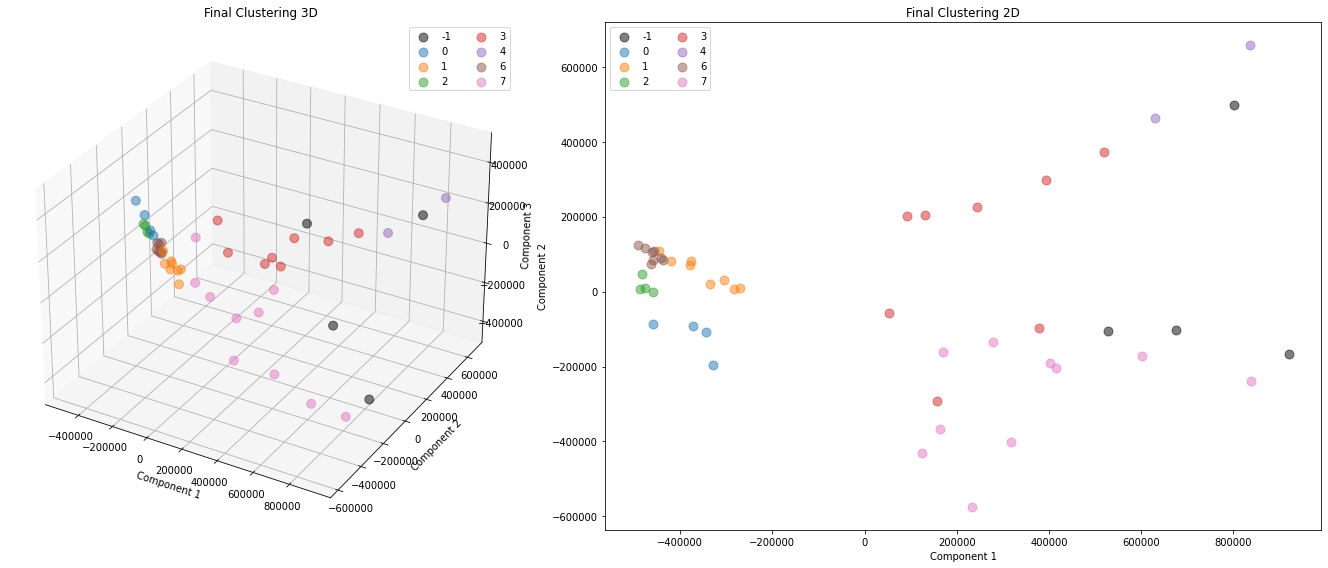

In [18]:
x_pca = PCA(n_components=n_components).fit_transform(x_array)

fig = plt.figure(figsize=(20, 8))

ax = fig.add_subplot(121, projection='3d')
plt.title('Final Clustering 3D')
for k in np.unique(cluster_tags):
    indexes = np.where(cluster_tags == k)[0]
    if k == -1:
        ax.scatter(x_pca[indexes, 0], x_pca[indexes, 1], x_pca[indexes, 2], alpha=0.5, s=80, label=k, c='k')
    else:
        ax.scatter(x_pca[indexes, 0], x_pca[indexes, 1], x_pca[indexes, 2], alpha=0.5, s=80, label=k)
ax.set_xlabel('Component 1')
ax.set_ylabel('Component 2')
ax.set_zlabel('Component 3')
plt.legend(ncol=2)
plt.tight_layout()

ax = fig.add_subplot(122)
plt.title('Final Clustering 2D')
for k in np.unique(cluster_tags):
    indexes = np.where(cluster_tags == k)[0]
    if k == -1:
        plt.scatter(x_pca[indexes, 0], x_pca[indexes, 1], alpha=0.5, s=80, label=k, c='k')
    else:
        plt.scatter(x_pca[indexes, 0], x_pca[indexes, 1], alpha=0.5, s=80, label=k)
ax.set_xlabel('Component 1')
ax.set_ylabel('Component 2')
plt.legend(ncol=2)
plt.tight_layout()

plt.show()

In [19]:
import networkx as nx

G = nx.Graph()

edges_width = {}
positions = {}
for k, (subject, related_subs) in enumerate(all_relations.items()):
    G.add_node(subject)
    positions[subject] = x_pca[k, 0:2]
    for sub in related_subs:
        if G.has_edge(subject, sub):
            edges_width[subject + ' -> ' + sub] = 3
        else:
            G.add_edge(subject, sub)
            edges_width[subject + ' -> ' + sub] = 1

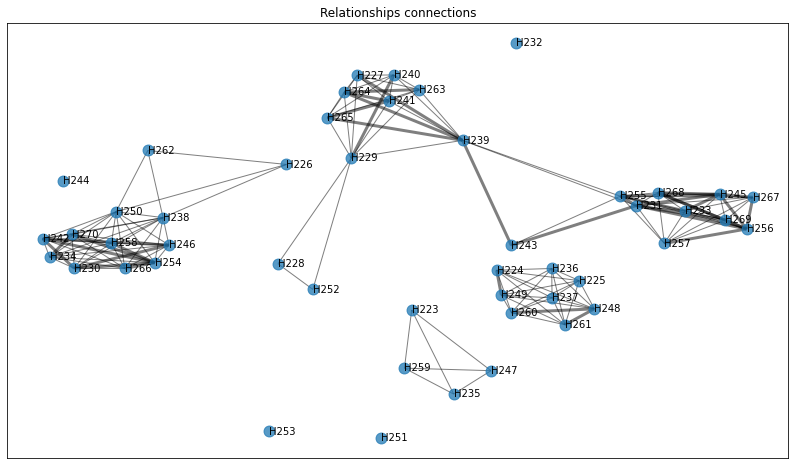

In [20]:
plt.figure(figsize=(14, 8))
plt.title("Relationships connections")

pos = nx.spring_layout(G, k=4/(48**0.5))

nx.draw_networkx_nodes(G, pos, node_size=120,  alpha=0.75)
nx.draw_networkx_labels(G, pos, font_size=10, horizontalalignment='left')
nx.draw_networkx_edges(G, pos, alpha=0.5, width=list(edges_width.values()), arrows=True)

plt.show()